# Life Expectancy Analysis

3 steps to this analysis:

1. Data Cleaning
2. Data Exploration - Visualisation
3. Summary

#### **Loading in the datasets**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
%matplotlib inline

#Load data and manipulate as needed
df = pd.read_csv("/content/led.csv")

df.head()

,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### **Section 1. Data Cleaning**
It is important to understand the variables presented in this data. To gain a deeper understanding there are 3 very important questions:

1. What is the meaning of the variable and what type of variable is it, i.e., nominal, ordinal, interval, or ratio?
2. Are there any missing values in the variable? If yes, how should they be handled?
3. Are there any outliers in the variable? If yes, how should they be addressed?

#### **1.1: Dataset Description/Variable Descriptions**

Below is a list of the variable descriptions from the World Health Organisation (WHO)

I have also cleaned up the variable names.

In [35]:
orig_cols = list(df.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = new_cols
df.columns

Index(['country', 'year', 'status', 'lifeexpectancy', 'adultmortality',
       'infantdeaths', 'alcohol', 'percentageexpenditure', 'hepatitisb',
       'measles', 'bmi', 'under-fivedeaths', 'polio', 'totalexpenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness1-19years',
       'thinness5-9years', 'incomecompositionofresources', 'schooling'],
      dtype='object')

##### **Variable Descriptions**

*   country (Nominal) - the country in which the indicators are from (i.e. United States of America or Congo)
*   year (Ordinal) - the calendar year the indicators are from (ranging from 2000 to 2015)
*   status (Nominal) - whether a country is considered to be 'Developing' or 'Developed' by WHO standards
*   lifeexpectancy (Ratio) - the life expectancy of people in years for a particular country and year
*   adultmortality (Ratio) - the adult mortality rate per 1000 population (i.e. number of people dying between 15 and 60 years per 1000 population); if the rate is 263 then that means 263 people will die out of 1000 between the ages of 15 and 60; another way to think of this is that the chance an individual will die between 15 and 60 is 26.3%
*   infantdeaths (Ratio) - number of infant deaths per 1000 population; similar to above, but for infants
*   alcohol (Ratio) - a country's alcohol consumption rate measured as liters of pure alcohol consumption per capita
percentage_expenditure (Ratio) - expenditure on health as a percentage of Gross Domestic Product (gdp)
*   hepatitisb (Ratio) - number of 1 year olds with Hepatitis B immunization over all 1 year olds in population
*   measles (Ratio) - number of reported Measles cases per 1000 population
*   bmi (Interval/Ordinal) - average Body Mass Index (BMI) of a country's total population
*   under-fivedeaths (Ratio) - number of people under the age of five deaths per 1000 population
*   polio (Ratio) - number of 1 year olds with Polio immunization over the number of all 1 year olds in population
*   totalexpenditure (Ratio) - government expenditure on health as a percentage of total government expenditure
*   diphtheria (Ratio) - Diphtheria tetanus toxoid and pertussis (DTP3) immunization rate of 1 year olds
*   hiv/aids (Ratio) - deaths per 1000 live births caused by HIV/AIDS for people under 5; number of people under 5 who die due to HIV/AIDS per 1000 births
*   gdp (Ratio) - Gross Domestic Product per capita
*   population (Ratio) - population of a country
*   thinness1-19_years (Ratio) - rate of thinness among people aged 10-19 (Variable will be renamed to thinness10-19_years to more accurately represent the variable)
*   thinness5-9_years (Ratio) - rate of thinness among people aged 5-9
*   incomecompositionofresources (Ratio) - Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
*   schooling (Ratio) - average number of years of schooling of a population



In [36]:
#Change the name of the variable thinness_1-19_years to thinness_10-19_years - more accurate
df.rename(columns={'thinness1-19years':'thinness10-19years'}, inplace=True)

#### **1.2: Missing Values**
There are few things that must be done concerning missing values:

1. Detection of missing values
> *   Find nulls
> *   Could a null be signified by anything other than null? Zero values perhaps?

2. Dealing with missing values
> *   Fill nulls? Impute or Interpolate
> *   Eliminate nulls?

**1. Missing Values Detection**

*   What values could be null?
*   What values could be erroneous?

Going to use df.describe() to look at each variable on its own to see if the values make sense given the description of the variable.

In [37]:
df.describe().iloc[:, 1:]

,lifeexpectancy,adultmortality,infantdeaths,alcohol,percentageexpenditure,hepatitisb,measles,bmi,under-fivedeaths,polio,totalexpenditure,diphtheria,hiv/aids,gdp,population,thinness10-19years,thinness5-9years,incomecompositionofresources,schooling
count,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


Things that may not make sense from above:

*   Minimum Adult mortality of 1 - this is likely an error in measurement, but what values make sense here? May need to change to null if under a certain threshold.
*   Minimum Infant deaths as low as 0 per 1000 -  not possible. Going to change these values to null. Also on the other end 1800 is likely an outlier, but it is possible in a country with very high birthrates and perhaps a not very high population total - this can be dealt with later.
*   Lowest BMI of 1 and highest 87.3? A BMI of 15 or lower is dangerously underweight and a BMI of 40 or higher is morbidly obese, therefore a large number of these measurements seems unrealistic. This variable might not be very good quality
*   Minimum Under Five Deaths as low as 0 - similar to infant deaths, not possible
*   GDP per capita as low as 1.68 (USD) - Doubtful - but perhaps values this low are outliers.
*   Population of 34 for an entire country seems off

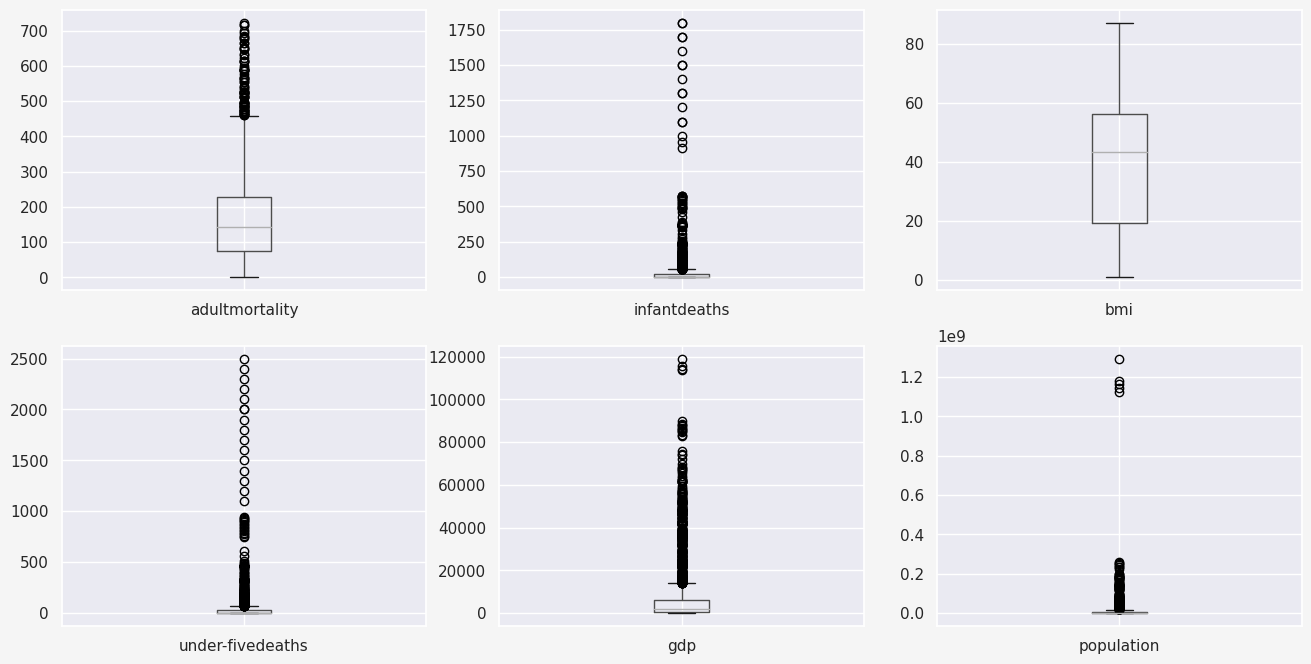

In [38]:
plt.figure(figsize=(16,8))
for i, col in enumerate(['adultmortality', 'infantdeaths', 'bmi', 'under-fivedeaths', 'gdp', 'population'], start=1):
    plt.subplot(2, 3, i)
    df.boxplot(col)

Some of the values above may be considered outliers, but there are some that are almost certainly errors. For the following variables, null values will be assigned because the values do not appear to be valid:

*   Adult mortality rates lower than the 5th percentile
*   Infant deaths of 0
*   BMI less than 10 and greater than 50
*   Under Five deaths of 0

In [39]:
#calculate the 5th percentile of non-null values 
mort_5_percentile = np.percentile(df.adultmortality.dropna(), 5)

#Replaces any adultmortality value less than the 5th percentile value with NaN (missing value)
df.adultmortality = df.apply(lambda x: np.nan if x.adultmortality < mort_5_percentile else x.adultmortality, axis=1)

#Replace all 0 values with NaN
df.infantdeaths = df.infantdeaths.replace(0, np.nan)

#Replaces any values less than 10 or higher than 50 with NaN
df.bmi = df.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)

#Replace all 0 values with NaN
df['under-fivedeaths'] = df['under-fivedeaths'].replace(0, np.nan)

Check for nulls:

In [40]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))
  
nulls_breakdown()

[iloc = 3] lifeexpectancy has 10 null values: 0.34% null
[iloc = 4] adultmortality has 155 null values: 5.28% null
[iloc = 5] infantdeaths has 848 null values: 28.86% null
[iloc = 6] alcohol has 194 null values: 6.6% null
[iloc = 8] hepatitisb has 553 null values: 18.82% null
[iloc = 10] bmi has 1456 null values: 49.56% null
[iloc = 11] under-fivedeaths has 785 null values: 26.72% null
[iloc = 12] polio has 19 null values: 0.65% null
[iloc = 13] totalexpenditure has 226 null values: 7.69% null
[iloc = 14] diphtheria has 19 null values: 0.65% null
[iloc = 16] gdp has 448 null values: 15.25% null
[iloc = 17] population has 652 null values: 22.19% null
[iloc = 18] thinness10-19years has 34 null values: 1.16% null
[iloc = 19] thinness5-9years has 34 null values: 1.16% null
[iloc = 20] incomecompositionofresources has 167 null values: 5.68% null
[iloc = 21] schooling has 163 null values: 5.55% null
Out of 22 total columns, 16 contain null values; 72.73% columns contain null values.


**2. Dealing with Missing Values**

Nearly half of the BMI variable's values are null therefore it is best to remove this variable

In [41]:
df.drop(columns='bmi', inplace=True)

There are numerous columns with missing values in the time series data. Since the data is sorted by country, interpolating the missing values by country may seem like a reasonable approach. However, since the data for all the null values is null for each year within a country, interpolation by country does not fill in any values. Thus, imputing the missing values with the mean value for each year may be the most appropriate method. The code below performs mean imputation for each year.

In [42]:
#Set up blank list
imputed_data = []
for year in list(df.year.unique()):
    #created year_data that contains only the records from df that match the current year in the loop
    year_data = df[df.year == year].copy()
    for col in list(year_data.columns)[3:]:
        #Replaces missing values with the mean value for that year
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
#Concat to stacking the dataframes vertically - on top of each other
df = pd.concat(imputed_data).copy()

#Check for nulls again
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

nulls_breakdown()

Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


#### **1.3 Outliers**

Similar to missing values, there are a few things that need done in order to deal with outliers:

1. Detect the outliers
> *   Boxplots/histograms
> *   Tukey's Method
2. Deal with outliers
> *   Drop outliers?
> *   Limit/Winsorise outliers?
> *   Transform the data using log/inverse/square root/etc?

**1. Outliers Detection**

First a boxplot and histogram will be created for each continuous variable in order to visually see if outliers exist.

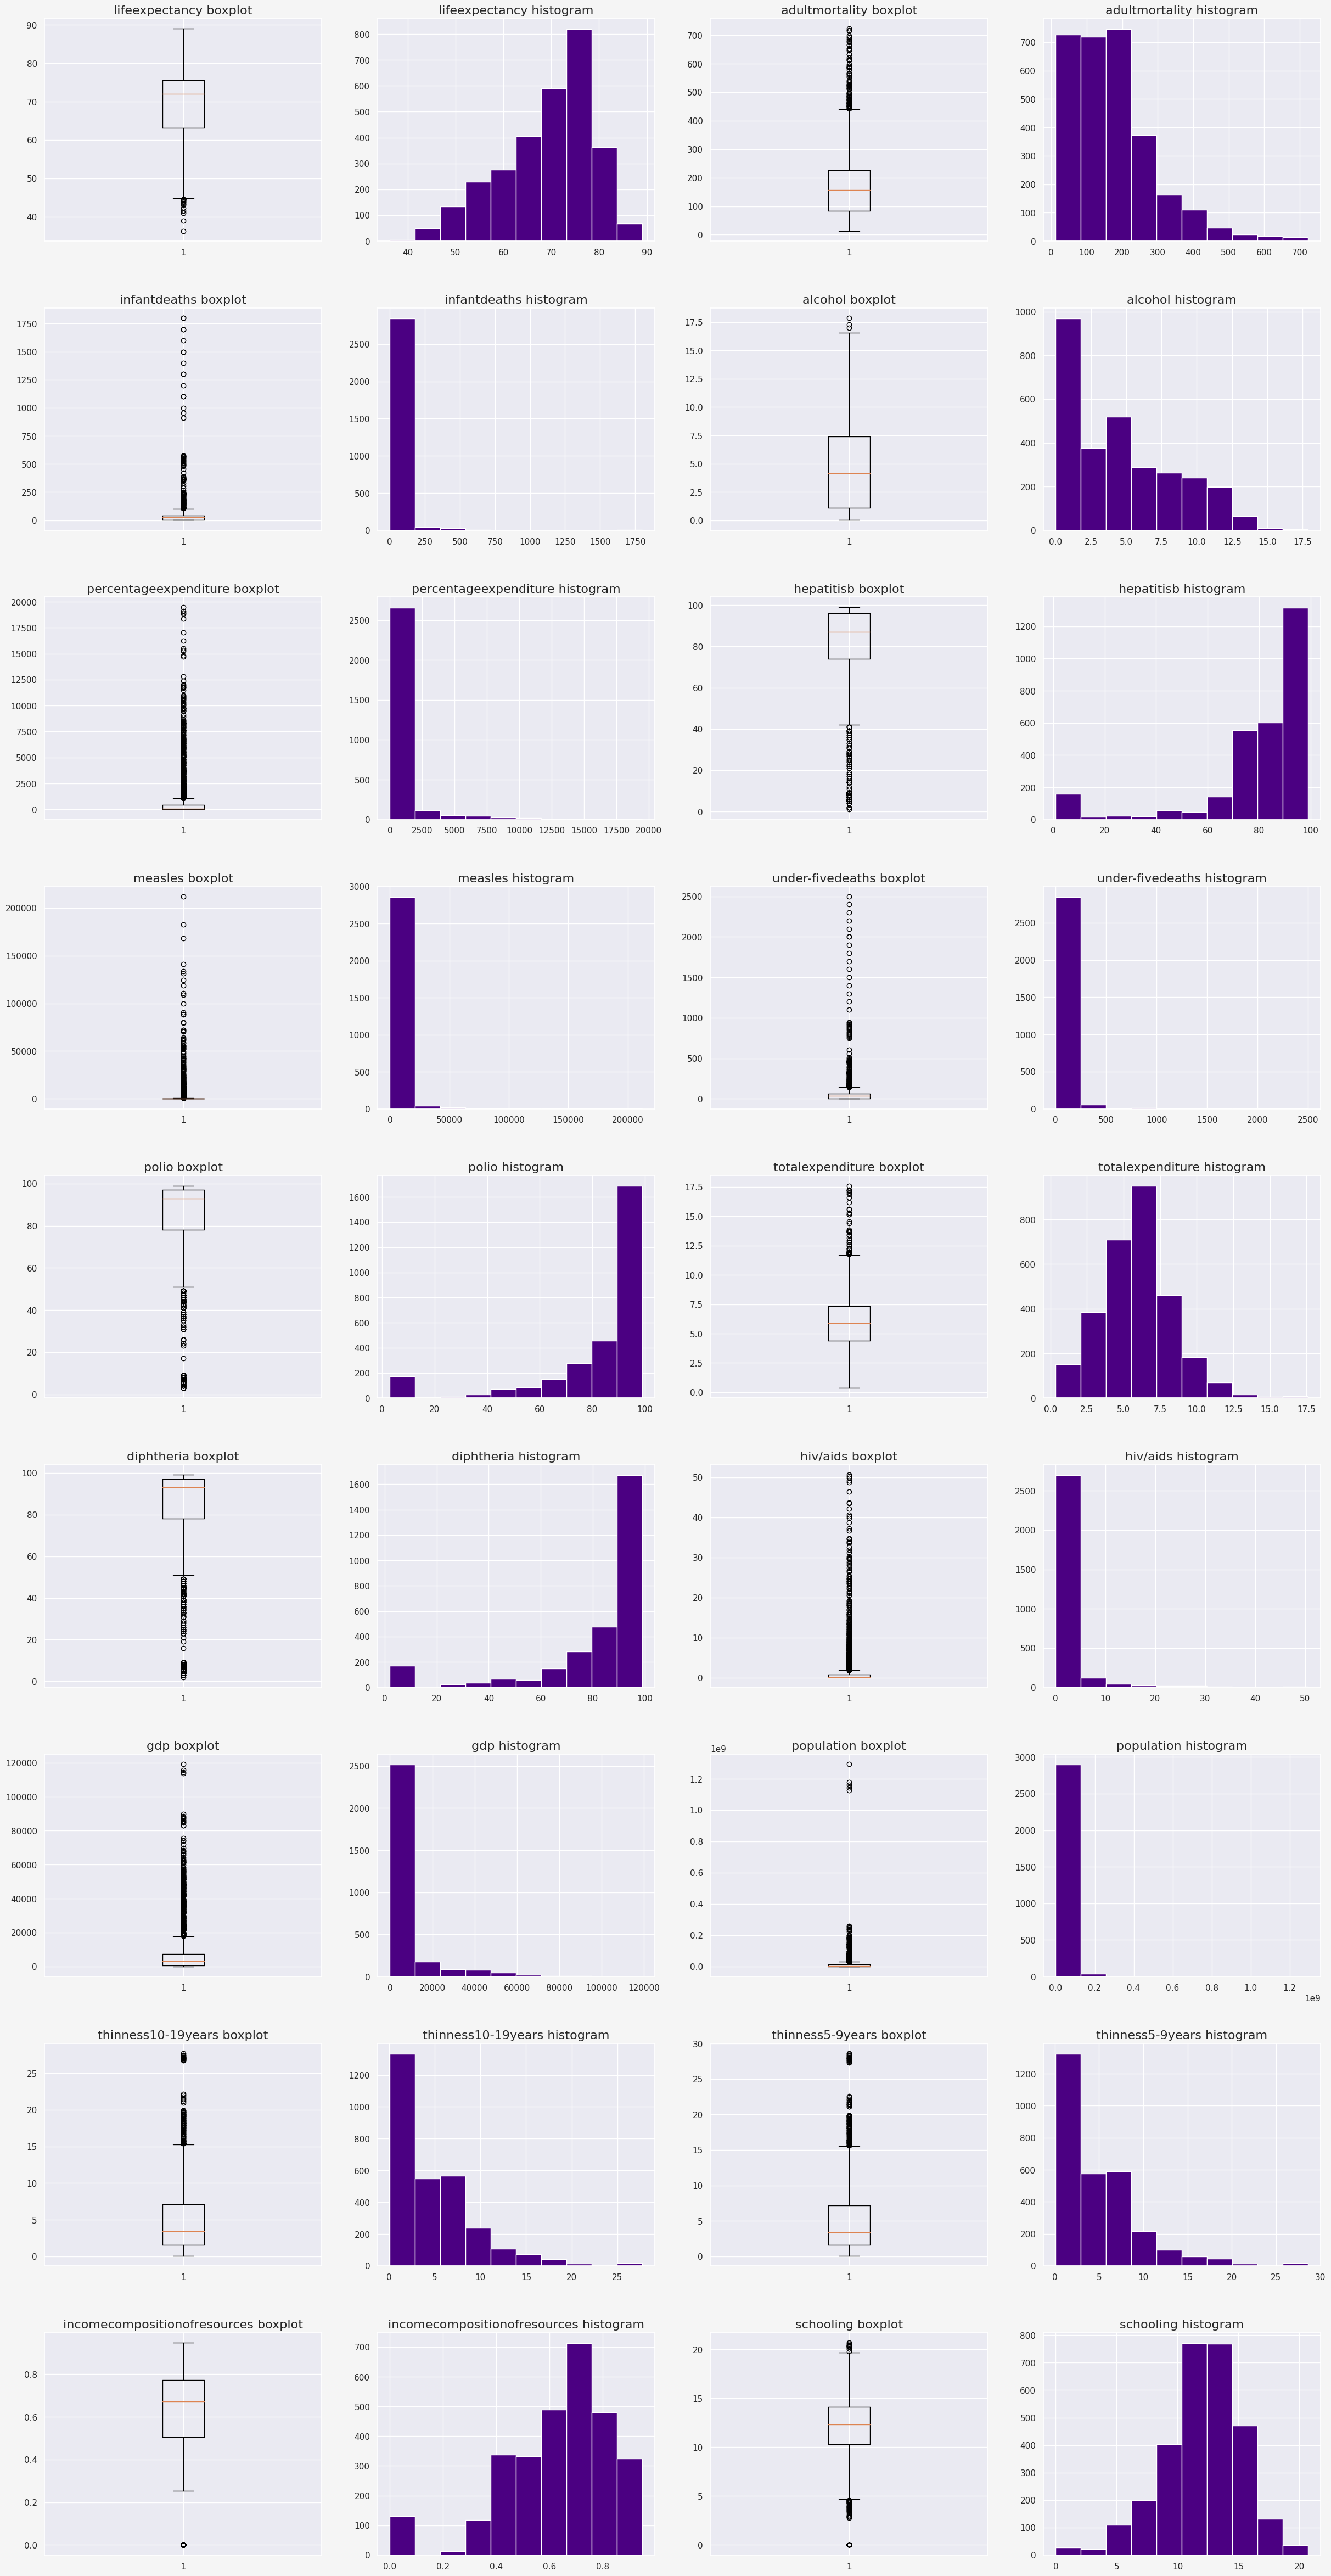

In [43]:
# Select continuous variables from the dataframe
cont_vars = list(df.columns)[3:]

def visualize_outliers(data):
    # Define the size of the figure and the number of subplots per row and column
    fig = plt.figure(figsize=(30, 60))
    rows, cols = 9, 4

    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col), fontsize = 16)
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col], color='indigo')
        plt.title('{} histogram'.format(col), fontsize = 16)

        # Adjust the spacing between subplots and display the figure
        plt.subplots_adjust(hspace=0.3)

    plt.show()

visualize_outliers(df)

By visual inspection, it is evident that there exist several outliers for all the variables, including the target variable of life expectancy. The application of Tukey's method below will confirm this statistically, where anything beyond 1.5 times the Interquartile Range (IQR) is considered an outlier.

In [44]:
#find outliers by specified criteria
def outlier_count(col, data=df):
    print(15*'-' + col + 15*'-')
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))
  
for col in cont_vars:
    outlier_count(col)

---------------lifeexpectancy---------------
Number of outliers: 17
Percent of data that is outlier: 0.58%
---------------adultmortality---------------
Number of outliers: 97
Percent of data that is outlier: 3.3%
---------------infantdeaths---------------
Number of outliers: 135
Percent of data that is outlier: 4.59%
---------------alcohol---------------
Number of outliers: 3
Percent of data that is outlier: 0.1%
---------------percentageexpenditure---------------
Number of outliers: 389
Percent of data that is outlier: 13.24%
---------------hepatitisb---------------
Number of outliers: 222
Percent of data that is outlier: 7.56%
---------------measles---------------
Number of outliers: 542
Percent of data that is outlier: 18.45%
---------------under-fivedeaths---------------
Number of outliers: 142
Percent of data that is outlier: 4.83%
---------------polio---------------
Number of outliers: 279
Percent of data that is outlier: 9.5%
---------------totalexpenditure---------------
Number

**2. Dealing with Outliers**

There are a number of ways to deal with outliers in a dataset, the usual options are as follows:

*   Drop Outliers (best avoided in order to keep as much information as possible)
*   Limit values to upper and/or lower bounds (Winsorize the data)
*   Transform the data (log/inverse/square root/etc.)
advantage: can 'normalize' the data and eliminate outliers
disadvantage: cannot be done to variables containing values of 0 or below


As each variable has a distinct number of outliers and these outliers are situated on different sides of the data, it is advisable to use winsorisation to restrict the values for each variable until all outliers are eliminated. To accomplish this, the function below processes each variable individually and permits the use of either a lower or upper limit for winsorisation. The function displays two boxplots (one displaying the original data and the other displaying the winsorised data) side by side for each variable by default. Once an acceptable limit is identified through visual examination, the winsorised data is saved in the wins_dict dictionary, allowing easy access to the data later on.

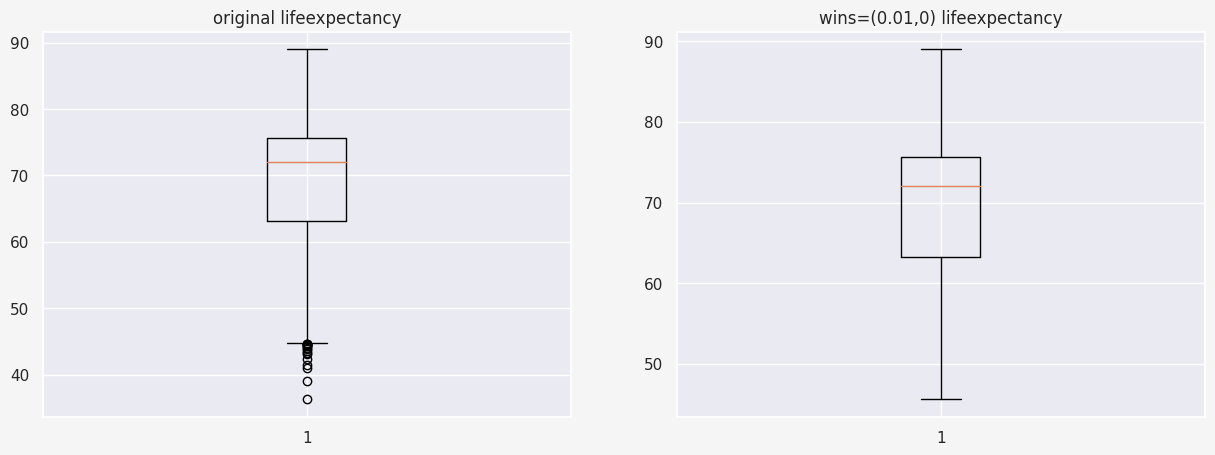

In [45]:
#Testing different upper/lower limits to find acceptable limits
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(df[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(df[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

wins_dict = {}
test_wins(cont_vars[0], lower_limit=.01, show_plot=True)
test_wins(cont_vars[1], upper_limit=.04, show_plot=False)
test_wins(cont_vars[2], upper_limit=.05, show_plot=False)
test_wins(cont_vars[3], upper_limit=.0025, show_plot=False)
test_wins(cont_vars[4], upper_limit=.135, show_plot=False)
test_wins(cont_vars[5], lower_limit=.1, show_plot=False)
test_wins(cont_vars[6], upper_limit=.19, show_plot=False)
test_wins(cont_vars[7], upper_limit=.05, show_plot=False)
test_wins(cont_vars[8], lower_limit=.1, show_plot=False)
test_wins(cont_vars[9], upper_limit=.02, show_plot=False)
test_wins(cont_vars[10], lower_limit=.105, show_plot=False)
test_wins(cont_vars[11], upper_limit=.185, show_plot=False)
test_wins(cont_vars[12], upper_limit=.105, show_plot=False)
test_wins(cont_vars[13], upper_limit=.07, show_plot=False)
test_wins(cont_vars[14], upper_limit=.035, show_plot=False)
test_wins(cont_vars[15], upper_limit=.035, show_plot=False)
test_wins(cont_vars[16], lower_limit=.05, show_plot=False)
test_wins(cont_vars[17], lower_limit=.025, upper_limit=.005, show_plot=False)

All the variables have now been winsorised as little as possible in order to keep as much data in tact as possible while still being able to eliminate the outliers. Finally, small boxplots will be shown for each variable's winsorized data to show that the outliers have indeed been dealt with.

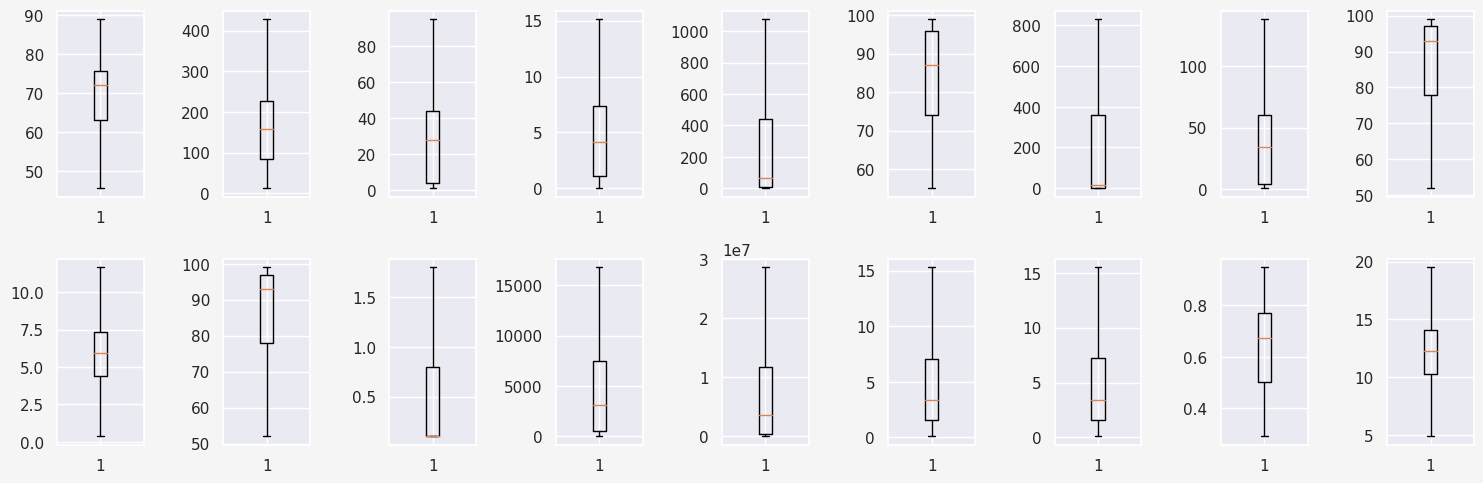

In [46]:
#@title
plt.figure(figsize=(15,5))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

Creating the new dataframe with the winsorised data

In [47]:
df_win = df.iloc[:, 0:3]
for col in cont_vars:
    df_win[col] = wins_dict[col]

### **Section 2: Data Exploration - Visualisation**

#### **Descriptive Statistics**

In [48]:
df_win.describe()

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' 

,year,lifeexpectancy,adultmortality,infantdeaths,alcohol,percentageexpenditure,hepatitisb,measles,under-fivedeaths,polio,totalexpenditure,diphtheria,hiv/aids,gdp,population,thinness10-19years,thinness5-9years,incomecompositionofresources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.248795,169.191269,28.607323,4.640667,281.501093,83.671293,220.691287,38.640545,85.514684,5.972192,85.469564,0.526991,5033.943592,7.508368e+06,4.703351,4.720470,0.640659,12.049874
std,4.613841,9.462136,107.646049,25.699534,3.910036,384.161450,13.848933,329.192321,37.732345,15.270927,2.302224,15.217611,0.675962,5408.511820,8.646842e+06,3.925702,3.964268,0.171622,3.085673
min,2000.000000,45.600000,13.000000,1.000000,0.010000,0.000000,55.000000,0.000000,1.000000,52.000000,0.370000,52.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,4.900000
25%,2004.000000,63.200000,84.000000,4.000000,1.092500,4.685343,74.099237,0.000000,4.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,157.000000,28.000000,4.140000,64.912906,87.000000,17.000000,34.000000,93.000000,5.910000,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.600000,227.000000,43.766917,7.390000,441.534144,96.000000,360.250000,60.014815,97.000000,7.330000,97.000000,0.800000,7464.487887,1.181332e+07,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,428.000000,95.000000,15.140000,1077.712092,99.000000,831.000000,138.000000,99.000000,11.660000,99.000000,1.800000,16784.346160,2.865628e+07,15.300000,15.500000,0.948000,19.500000


#### **Visual Distributions**

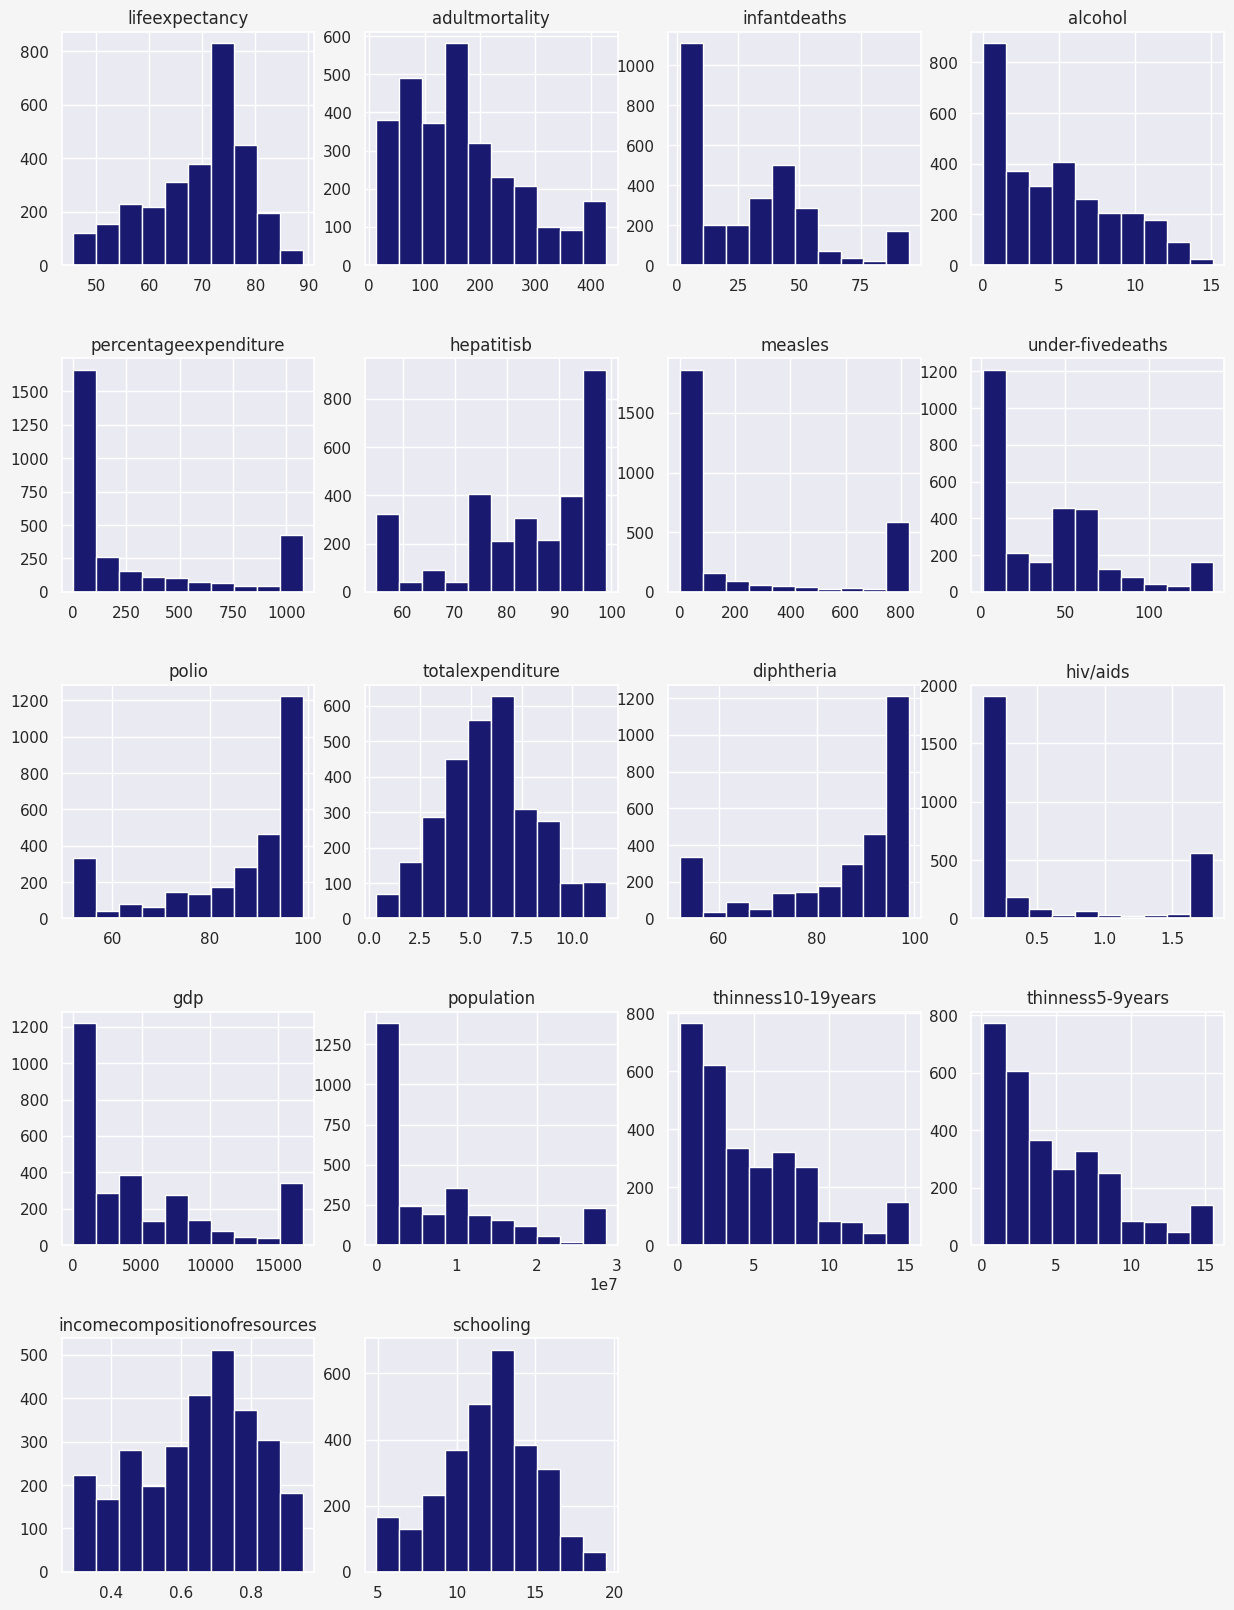

In [49]:
# Creating the histograms
plt.figure(figsize=(15, 20))
# Iterate over the columns and plot a histogram for each
for i, col in enumerate(cont_vars, 1):
    # Set the number of rows and columns in the plot grid and selects the current plot to be i
    plt.subplot(5, 4, i)
    plt.hist(df_win[col], color = 'midnightblue')
    plt.title(col)
    # Adjust the spacing between the subplots
    plt.subplots_adjust(hspace=0.4)

#### **Life Expectancy over time**

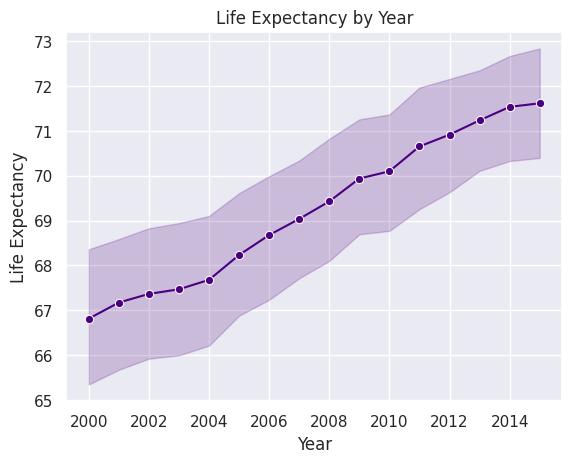

In [50]:
# Set the Seaborn theme
sns.set_theme()

# Create a scatter plot
sns.lineplot(x="year", y="lifeexpectancy", data=df_win, color='indigo', marker = 'o')

# Add a title and axis labels to the plot
plt.title('Life Expectancy by Year')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')

# Set the plot background color to pale grey
plt.rcParams["figure.facecolor"] = "#F5F5F5"

# Set the gridline color to white
plt.rcParams["grid.color"] = "white"

# Show the plot
plt.show()

There appears to be a positive trend over time with life expectancy increasing gradually year on year.

#### **Continuous Variable Correlation**

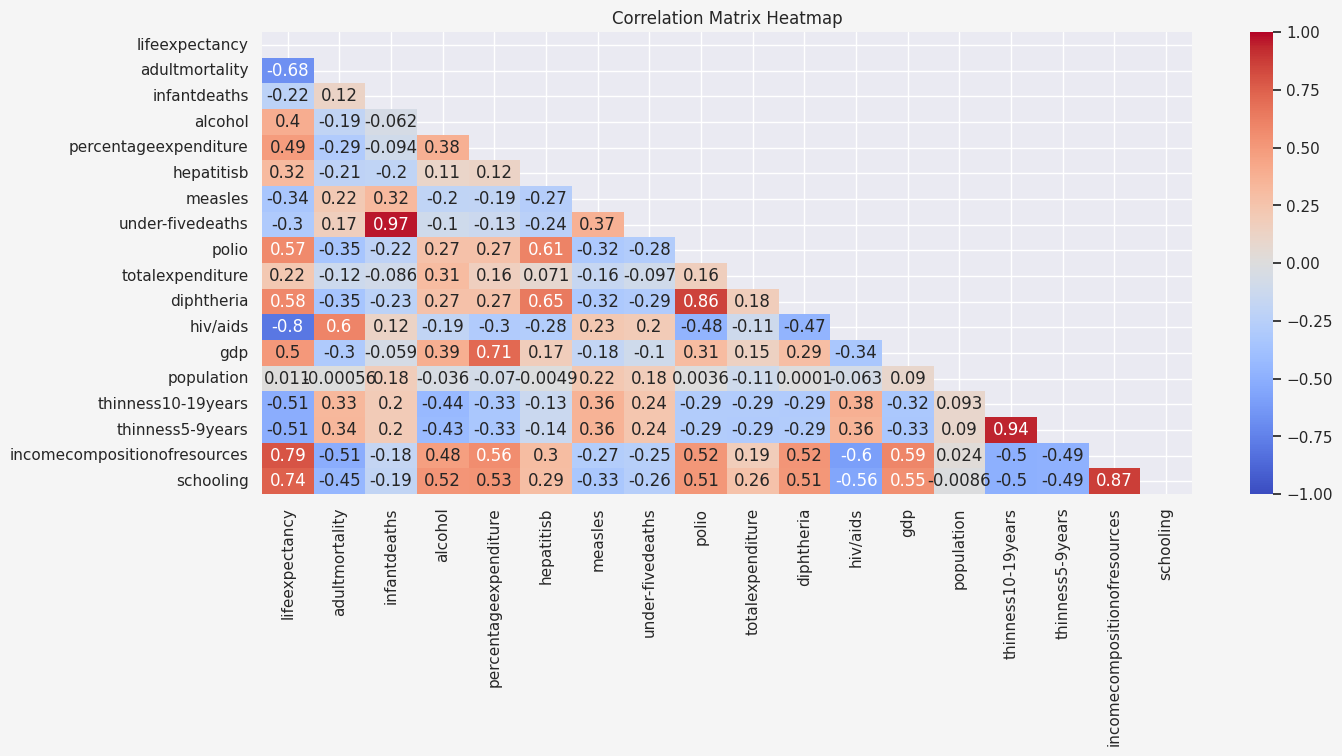

In [51]:
#Create a heatmap of the correlation matrix for the continuous variables in the dataset.
def plot_correlation_matrix(data):
    # Compute the correlation matrix and create a mask to show only the upper triangle
    corr = df_win[cont_vars].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Define the size and style of the figure and plot the heatmap
    plt.figure(figsize=(15,6))
    sns.heatmap(corr, annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    
    # Set the y-axis limits and add a title to the plot
    plt.ylim(len(cont_vars), 0)
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    
# Call the function to plot the correlation matrix for the dataframe
plot_correlation_matrix(df_win)

We can see from the above heatmap a number of important correlations:

*   Life Expectancy (target variable) appears to be relatively highly correlated with:
>*   Adult Mortality (negative)
>*   HIV/AIDS (negative)
>*   Income Composition of Resources (positive)
>*   Schooling (positive)

* The correlation between life expectancy and adult mortality with population is very weak

* The correlation between population and all variables is very weak except for with measles, infant deaths and under 5 deaths (still pretty low correlation with these 3 also but not as low)

*  Infant deaths and under 5 deaths are very hightly correlated

* Polio vaccine rate is very highly corrected with diptheria vaccine rate

* Hepatitis B vaccione rate is highly correlated with both polio and diptheria vaccine rates

* Income composition of resources and schooling are very highly correlated

* Thinness 5-9 years is very highly correlated with thinness 10-19 years

#### **Correlation Scatterplots**

**1. Life Expectancy and Adult Mortality**

The chart below shows the correlation between life expectancy and adult mortality as a scatter plot. The year displayed is 2014.

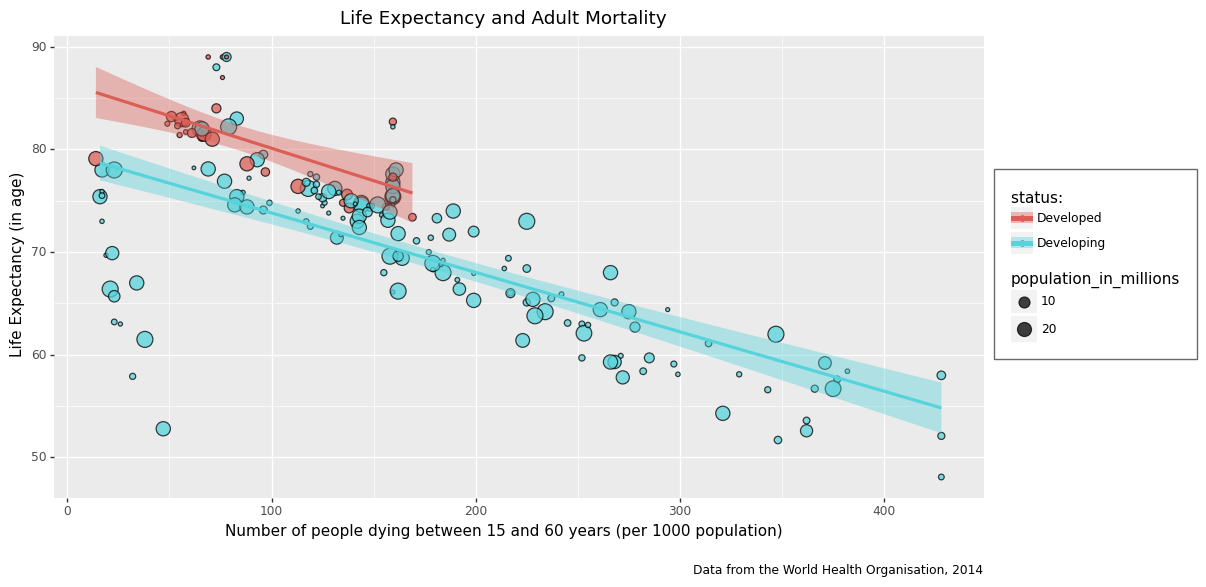

<ggplot: (8747015630791)>

In [52]:
#@title
#Load packages
from plotnine import *

#add column to df for population in millions
df_win['population_in_millions'] = df_win['population'] / 1000000

#Filter df for only 2014
df_plot_2014 = df_win[df_win['year']==2014]

#Create chart
(
ggplot(df_plot_2014)
#Set up variables for x and y and what variable the colour and size of points are determined by
+ aes(x = 'adultmortality', y = 'lifeexpectancy', fill='status', size = 'population_in_millions') 
+ geom_point(alpha=0.75)
+ theme(figure_size=(12, 6),
        legend_background=element_rect(fill='white', color='dimgray'))
+ geom_smooth(aes(colour = 'status'), method = "gls", size = 1.3, formula = 'y ~ x')
+ labs(x="Number of people dying between 15 and 60 years (per 1000 population)",
       y="Life Expectancy (in age)", 
       title="Life Expectancy and Adult Mortality",
       caption = 'Data from the World Health Organisation, 2014',
       fill="status: ", 
       colour="status: ")
)

Findings from the chart:

We can see clearly in this chart the correlation between life expectancy and adult mortality (number of people dying between 15 and 60 years old per 1000 population) that was given in the correlation matrix above.

Developed countries generally have longer life expectancies, whereas developing countries tend to have a higher probability of dying between the ages of 15 and 60. In both developing and developed countries, an increase in the probability of death between 15 and 60 years of age is associated with a decrease in life expectancy.

**2. Life Expectancy and Schooling**

The chart below shows the correlation between life expectancy and schooling as a scatter plot. The year displayed is 2014.

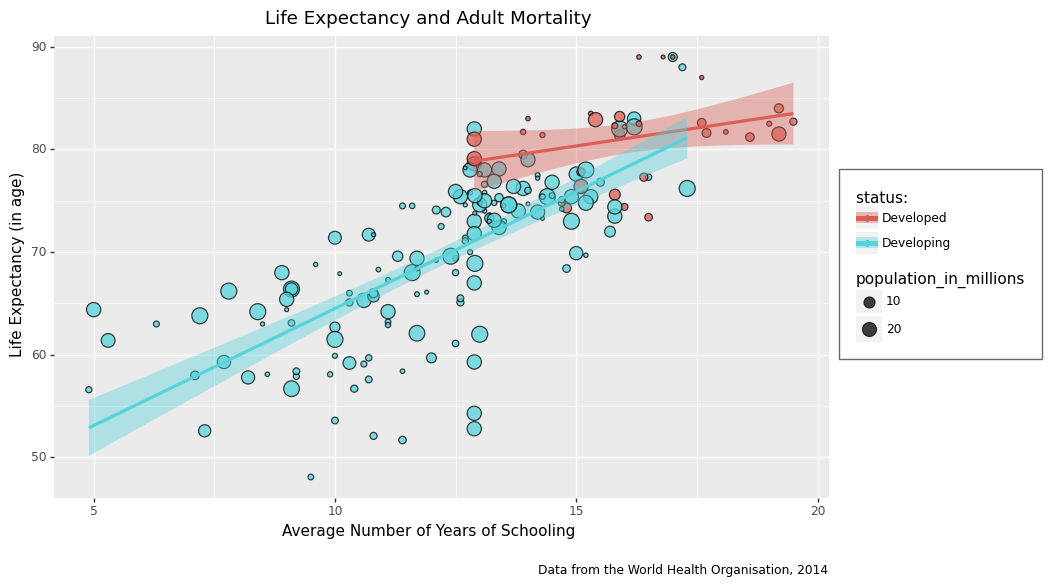

<ggplot: (8747015584799)>

In [53]:
#@title
#Create chart
(
ggplot(df_plot_2014)
#Set up variables for x and y and what variable the colour and size of points are determined by
+ aes(x = 'schooling', y = 'lifeexpectancy', fill='status', size = 'population_in_millions') 
+ geom_point(alpha=0.75)
+ theme(figure_size=(10, 6),
        legend_background=element_rect(fill='white', color='dimgray'))
+ geom_smooth(aes(colour = 'status'), method = "gls", size = 1.3, formula = 'y ~ x')
+ labs(x="Average Number of Years of Schooling",
       y="Life Expectancy (in age)", 
       title="Life Expectancy and Adult Mortality",
       caption = 'Data from the World Health Organisation, 2014',
       fill="status: ", 
       colour="status: ")
)

We examine the influence of education on life expectancy. The evidence shows a clear positive correlation between the number of years of education and the average life expectancy, particularly in developing countries. Furthermore, developed countries exhibit notably higher levels of both education and life expectancy in comparison to developing countries.

**3. Life Expectancy and GDP**

The chart below shows the correlation between life expectancy and GDP as a scatter plot. The year displayed is 2014.

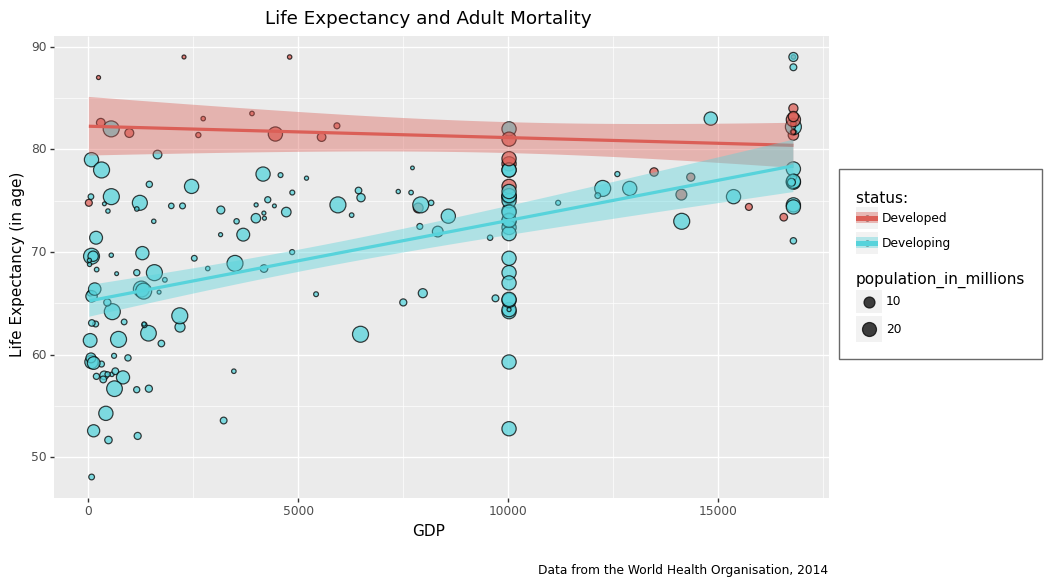

<ggplot: (8747020243571)>

In [54]:
#@title
#Create chart
(
ggplot(df_plot_2014)
#Set up variables for x and y and what variable the colour and size of points are determined by
+ aes(x = 'gdp', y = 'lifeexpectancy', fill='status', size = 'population_in_millions') 
+ geom_point(alpha=0.75)
+ theme(figure_size=(10, 6),
        legend_background=element_rect(fill='white', color='dimgray'))
+ geom_smooth(aes(colour = 'status'), method = "gls", size = 1.3, formula = 'y ~ x')
+ labs(x="GDP",
       y="Life Expectancy (in age)", 
       title="Life Expectancy and Adult Mortality",
       caption = 'Data from the World Health Organisation, 2014',
       fill="status: ", 
       colour="status: ")
)

There is a positive correlation between life expectancy and GDP for developing countries. The same correlation is not seen between life expectancy and GDP in developed countries - for these countries the correlation is fairly flat.